In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from helpers.SimulationAnalysis import readHlist
from fast3tree import fast3tree

## Plot JK errors

In [2]:
from AbundanceMatching import AbundanceFunction
from urllib import urlopen

x, phi_log = np.loadtxt(urlopen('http://arxiv.org/src/1304.7778v2/anc/LF_SerExp.dat'), usecols=(0,1)).T
af = AbundanceFunction(x, (10.**phi_log)*0.4/(0.7**3), ext_range=(-30.0, -5.0))

for Mr in np.arange(-22.0, -16.9, 0.5):
    print '{:.1f}  {:.3f}'.format(Mr, np.log10(af.number_density_at(Mr)))

-22.0  -3.281
-21.5  -2.903
-21.0  -2.617
-20.5  -2.391
-20.0  -2.222
-19.5  -2.095
-19.0  -1.985
-18.5  -1.890
-18.0  -1.805
-17.5  -1.739
-17.0  -1.692


In [3]:
#load data
proxies = ['vpeak', 'vmax', 'mvir', 'macc']
cases = ['c250-2048', 'c250-1024', 'c250-768', 'c250-512', 
         'c400-2048', 'c400-1024', 'c400-768', 'c125-2048-new', 'c125-1024']
nd_log_list = np.linspace(-3.3, -1.7, 17)

rbins = np.logspace(-1.3, 1.3, 27)

_pairs_cache_JK = {}
def load_pair_countJK(proxy, case, nd_log, fixed_limits=False):
    key = (proxy, case, nd_log, 'f' if fixed_limits else 'c')
    if key not in _pairs_cache_JK:
        test = np.load('/nfs/slac/g/ki/ki22/cosmo/iameric/resolution_study/pairs_{}/{}_nd{:.1f}_{}.npy'.format(*key))
        _pairs_cache_JK[key] = np.load('/nfs/slac/g/ki/ki22/cosmo/iameric/resolution_study/pairs_{}/{}_nd{:.1f}_{}.npy'.format(*key))    
    return _pairs_cache_JK[key]

_nd_limits = {}
def load_nd_limits(proxy, case):
    key = (proxy, case)
    if key not in _nd_limits:
        _nd_limits[key] = np.load('/nfs/slac/g/ki/ki06/yymao/resolution_test/pairs_{}/{}_nd_limits.npy'.format(*key))     
    return _nd_limits[key]

In [4]:
#Doing Jackknife with the pair indices

def pair_count_JK(pairs_list, JKindex, nJK = 2, nsaved = 50):
    pairs_JK = np.zeros(len(pairs_list),'float')
    for i, pairs in enumerate(pairs_list):
        # calculate the number of pairs that are not in the JK box (both indices outside of the JK box)
        idx, idy, idz = np.unravel_index(np.arange(nsaved**3),(nsaved, nsaved, nsaved))
        r = int(nsaved/nJK)
        index_conversion = np.ravel_multi_index((idx/r, idy/r, idz/r),(nJK, nJK, nJK))
        index2bool = index_conversion != JKindex
        JKi1 = index2bool[pairs[:,0]]
        JKi2 = index2bool[pairs[:,1]]
        pairs_JK[i] = np.sum(JKi1*JKi2)
    return np.ediff1d(pairs_JK)

def JK_std(data, axis = 0):
    return np.sqrt(data.shape[axis] - 1)*np.std(data, axis = 0)

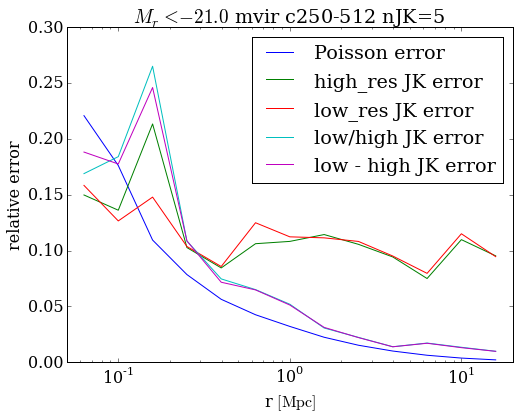

In [8]:
#load pair indices
#c2048 = np.array([load_pair_countJK('mvir', 'c250-2048', nd) for nd in nd_log_list])
case = 'c250-512'
proxy = 'mvir'
#125 Jackknives
nJK = 5

nd_log = -2.6
highres = load_pair_countJK(proxy, 'c250-2048', nd_log)
lowres = load_pair_countJK(proxy, case, nd_log)
highJK = np.array([pair_count_JK(highres, i, nJK) for i in range(nJK**3)])
lowJK = np.array([pair_count_JK(lowres, i, nJK) for i in range(nJK**3)])
plt.rcParams['font.size'] = 16.0
plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['font.family'] = 'serif'
total1 = np.ediff1d(np.array([float(len(i)) for i in highres]))
total2 = np.ediff1d(np.array([float(len(i)) for i in lowres]))
plt.semilogx(rbins[1::2], np.sqrt(1/total1 + 1/total2)[::2], label = 'Poisson error')
plt.semilogx(rbins[1::2], (JK_std(highJK, axis = 0)/ np.mean(highJK, axis = 0))[::2], label ='high_res JK error')
plt.semilogx(rbins[1::2], (JK_std(lowJK, axis = 0)/ np.mean(lowJK, axis = 0))[::2], label ='low_res JK error')
plt.semilogx(rbins[1::2], (JK_std((lowJK-highJK) / highJK, axis = 0))[::2], label ='low/high JK error')
plt.semilogx(rbins[1::2], (JK_std((lowJK-highJK) / np.mean(highJK, axis = 0), axis = 0))[::2], label ='low - high JK error')
plt.xlim([0.05,20])
plt.xlabel(r'r $[{\rm Mpc}]$')
plt.ylabel('relative error')
plt.title('$M_r < {:.1f}$ '.format(af.match(10.0**nd_log)) + proxy + ' ' + case + ' nJK={} '.format(nJK))
plt.legend()

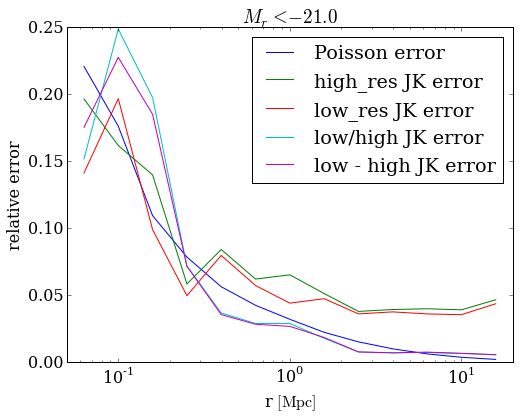

In [27]:
#load pair indices
#c2048 = np.array([load_pair_countJK('mvir', 'c250-2048', nd) for nd in nd_log_list])
nd_log = -2.6
highres = load_pair_countJK('mvir', 'c250-2048', nd_log)
lowres = load_pair_countJK('mvir', 'c250-512', nd_log)
#125 Jackknives
JKbox_size = 125
highJK = np.array([pair_count_JK(highres, i, JKbox_size=JKbox_size) for i in range((250/JKbox_size)**3)])
lowJK = np.array([pair_count_JK(lowres, i, JKbox_size=JKbox_size) for i in range((250/JKbox_size)**3)])
plt.rcParams['font.size'] = 16.0
plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['font.family'] = 'serif'
total1 = np.ediff1d(np.array([float(len(i)) for i in highres]))
total2 = np.ediff1d(np.array([float(len(i)) for i in lowres]))
plt.semilogx(rbins[1::2], np.sqrt(1/total1 + 1/total2)[::2], label = 'Poisson error')
plt.semilogx(rbins[1::2], (JK_std(highJK, axis = 0)/ np.mean(highJK, axis = 0))[::2], label ='high_res JK error')
plt.semilogx(rbins[1::2], (JK_std(lowJK, axis = 0)/ np.mean(lowJK, axis = 0))[::2], label ='low_res JK error')
plt.semilogx(rbins[1::2], (JK_std((lowJK-highJK) / highJK, axis = 0))[::2], label ='low/high JK error')
plt.semilogx(rbins[1::2], (JK_std((lowJK-highJK) / np.mean(highJK, axis = 0), axis = 0))[::2], label ='low - high JK error')
plt.xlim([0.05,20])
plt.xlabel(r'r $[{\rm Mpc}]$')
plt.ylabel('relative error')
plt.title('$M_r < {:.1f}$'.format(af.match(10.0**nd_log)))
plt.legend()

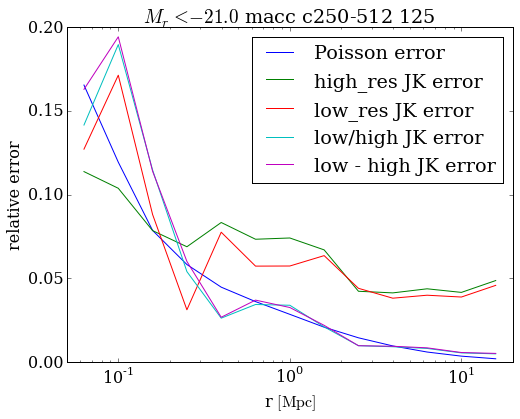

In [31]:
#load pair indices
#c2048 = np.array([load_pair_countJK('mvir', 'c250-2048', nd) for nd in nd_log_list])
case = 'c250-512'
proxy = 'macc'
JKbox_size = 125

nd_log = -2.6
highres = load_pair_countJK(proxy, 'c250-2048', nd_log)
lowres = load_pair_countJK(proxy, case, nd_log)
highJK = np.array([pair_count_JK(highres, i, JKbox_size=JKbox_size) for i in range((250/JKbox_size)**3)])
lowJK = np.array([pair_count_JK(lowres, i, JKbox_size=JKbox_size) for i in range((250/JKbox_size)**3)])
plt.rcParams['font.size'] = 16.0
plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['font.family'] = 'serif'
total1 = np.ediff1d(np.array([float(len(i)) for i in highres]))
total2 = np.ediff1d(np.array([float(len(i)) for i in lowres]))
plt.semilogx(rbins[1::2], np.sqrt(1/total1 + 1/total2)[::2], label = 'Poisson error')
plt.semilogx(rbins[1::2], (JK_std(highJK, axis = 0)/ np.mean(highJK, axis = 0))[::2], label ='high_res JK error')
plt.semilogx(rbins[1::2], (JK_std(lowJK, axis = 0)/ np.mean(lowJK, axis = 0))[::2], label ='low_res JK error')
plt.semilogx(rbins[1::2], (JK_std((lowJK-highJK) / highJK, axis = 0))[::2], label ='low/high JK error')
plt.semilogx(rbins[1::2], (JK_std((lowJK-highJK) / np.mean(highJK, axis = 0), axis = 0))[::2], label ='low - high JK error')
plt.xlim([0.05,20])
plt.xlabel(r'r $[{\rm Mpc}]$')
plt.ylabel('relative error')
plt.title('$M_r < {:.1f}$ '.format(af.match(10.0**nd_log)) + proxy + ' ' + case + ' {} '.format(JKbox_size))
plt.legend()

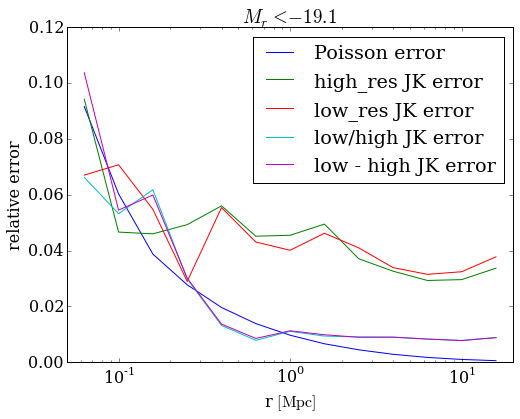

In [26]:
#load pair indices
#c2048 = np.array([load_pair_countJK('mvir', 'c250-2048', nd) for nd in nd_log_list])
nd_log = -2.0
highres = load_pair_countJK('mvir', 'c250-2048', nd_log)
lowres = load_pair_countJK('mvir', 'c250-512', nd_log)
#125 Jackknives
JKbox_size = 125
highJK = np.array([pair_count_JK(highres, i, JKbox_size=JKbox_size) for i in range((250/JKbox_size)**3)])
lowJK = np.array([pair_count_JK(lowres, i, JKbox_size=JKbox_size) for i in range((250/JKbox_size)**3)])
plt.rcParams['font.size'] = 16.0
plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['font.family'] = 'serif'
total1 = np.ediff1d(np.array([float(len(i)) for i in highres]))
total2 = np.ediff1d(np.array([float(len(i)) for i in lowres]))
plt.semilogx(rbins[1::2], np.sqrt(1/total1 + 1/total2)[::2], label = 'Poisson error')
plt.semilogx(rbins[1::2], (JK_std(highJK, axis = 0)/ np.mean(highJK, axis = 0))[::2], label ='high_res JK error')
plt.semilogx(rbins[1::2], (JK_std(lowJK, axis = 0)/ np.mean(lowJK, axis = 0))[::2], label ='low_res JK error')
plt.semilogx(rbins[1::2], (JK_std((lowJK-highJK) / highJK, axis = 0))[::2], label ='low/high JK error')
plt.semilogx(rbins[1::2], (JK_std((lowJK-highJK) / np.mean(highJK, axis = 0), axis = 0))[::2], label ='low - high JK error')
plt.xlim([0.05,20])
plt.xlabel(r'r $[{\rm Mpc}]$')
plt.ylabel('relative error')
plt.title('$M_r < {:.1f}$'.format(af.match(10.0**nd_log)))
plt.legend()

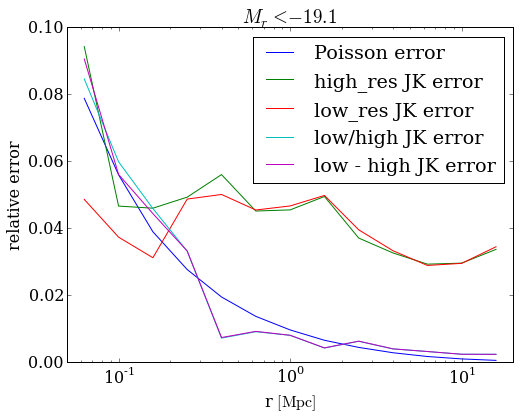

In [8]:
#load pair indices
#c2048 = np.array([load_pair_countJK('mvir', 'c250-2048', nd) for nd in nd_log_list])
nd_log = -2.0
highres = load_pair_countJK('mvir', 'c250-2048', nd_log)
lowres = load_pair_countJK('mvir', 'c250-1024', nd_log)
#125 Jackknives
JKbox_size = 125
highJK = np.array([pair_count_JK(highres, i, JKbox_size=JKbox_size) for i in range((250/JKbox_size)**3)])
lowJK = np.array([pair_count_JK(lowres, i, JKbox_size=JKbox_size) for i in range((250/JKbox_size)**3)])
plt.rcParams['font.size'] = 16.0
plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 16.0
plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['font.family'] = 'serif'
total1 = np.ediff1d(np.array([float(len(i)) for i in highres]))
total2 = np.ediff1d(np.array([float(len(i)) for i in lowres]))
plt.semilogx(rbins[1::2], np.sqrt(1/total1 + 1/total2)[::2], label = 'Poisson error')
plt.semilogx(rbins[1::2], (JK_std(highJK, axis = 0)/ np.mean(highJK, axis = 0))[::2], label ='high_res JK error')
plt.semilogx(rbins[1::2], (JK_std(lowJK, axis = 0)/ np.mean(lowJK, axis = 0))[::2], label ='low_res JK error')
plt.semilogx(rbins[1::2], (JK_std((lowJK-highJK) / highJK, axis = 0))[::2], label ='low/high JK error')
plt.semilogx(rbins[1::2], (JK_std((lowJK-highJK) / np.mean(highJK, axis = 0), axis = 0))[::2], label ='low - high JK error')
plt.xlim([0.05,20])
plt.xlabel(r'r $[{\rm Mpc}]$')
plt.ylabel('relative error')
plt.title('$M_r < {:.1f}$'.format(af.match(10.0**nd_log)))
plt.legend()
plt.savefig('plots/c250-1024_nd-2.0_JK_error.png')

## try to see assembly bias

In [185]:

#halos = readHlist('/u/ki/yymao/ki21/sham_test/resolution-test/c250-128/rockstar/hlists/hlist_1.00000.list'
#                  , ['mvir', 'x', 'y', 'z','rvir','rs'])

halos = readHlist('/u/ki/yymao/ki21/sham_test/resolution-test/c250-512/rockstar/hlists/hlist_1.00000.list',\
                 ['mvir', 'x', 'y', 'z','rvir','rs'])


#with fast3tree(halos1[['x', 'y', 'z']].view((float, 3))) as tree:
    # loop over halos
        # loop over r 
#        tree.query_radius(halo_pos, r, output='c')

(array([  4.41400000e+03,   9.23870000e+04,   1.63279000e+05,
          6.81490000e+04,   2.60090000e+04,   9.27200000e+03,
          2.95400000e+03,   8.33000000e+02,   1.55000000e+02,
          2.00000000e+01]),
 array([ 10.26670197,  10.75682255,  11.24694314,  11.73706372,
         12.2271843 ,  12.71730489,  13.20742547,  13.69754606,
         14.18766664,  14.67778723,  15.16790781]),
 <a list of 10 Patch objects>)

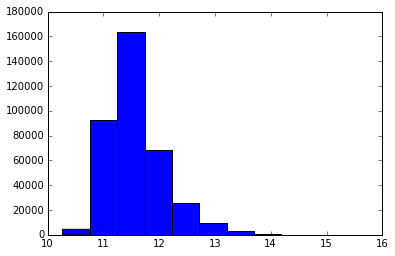

In [186]:
m = halos['mvir']
plt.hist(np.log10(m))

In [187]:
rbins = np.logspace(0, 1.5, 16)
def count_pairs(halos, m_cut, rbins = rbins):
    box_size = 250.
    halos_cut = halos[halos['mvir'] >= m_cut]
    loc = halos_cut[['x','y','z']].view(('float',3))

    with fast3tree(loc) as tree:
        pairs_cumulative = np.zeros_like(rbins)
        tree.set_boundaries(0, box_size)
        for p in loc:
            for i, r in enumerate(rbins):
                pairs_cumulative[i] += tree.query_radius(p, r, periodic=True, output='c')
    pairs = np.ediff1d(pairs_cumulative)
    return pairs

def count_random_pairs(m_cut, box_size = 250):
    N = len(halos[['x','y','z']][halos['mvir'] >= m_cut ])
    nhalos = N/float(box_size)**3
    random = N*nhalos*np.ediff1d(4*np.pi/3.*rbins**3)
    return random

In [188]:
pairs13 = count_pairs(halos, 10**13, rbins)
pairs12 = count_pairs(halos, 10**12, rbins)

In [189]:
pairs14 = count_pairs(halos, 10**14, rbins)

In [190]:
random13 = count_random_pairs(10**13, 250)
random12 = count_random_pairs(10**12, 250)
random14 = count_random_pairs(10**14, 250)

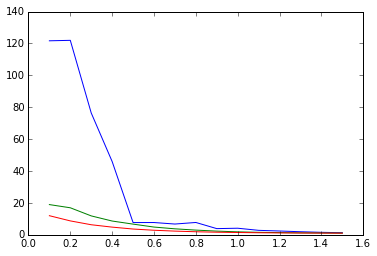

In [191]:
plt.plot(np.log10(rbins[1:]), pairs14/ random14)
plt.plot(np.log10(rbins[1:]), pairs13/ random13)
plt.plot(np.log10(rbins[1:]), pairs12/ random12)

#### different mass cutoffs

In [143]:
rbins = np.logspace(0, 1.5, 16)
m_cut = np.logspace(12,14,5)
pairs_list = np.array([count_pairs(halos,m) for m in m_cut])
random_pairs_list = np.array([count_random_pairs(m) for m in m_cut])

In [145]:
xi_list = pairs_list/ random_pairs_list

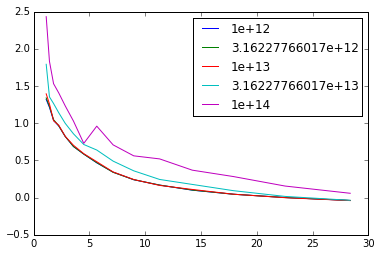

In [167]:
rcen = [(rbins[i] + rbins[i+1])/2  for i in range(len(rbins)-1)]
for i in range(len(xi_list)):
    plt.plot(rcen, np.log10(xi_list[i]), label = m_cut[i])
plt.legend()

#### Investigate how concentration relates to correlation

In [331]:
halos = readHlist('/u/ki/yymao/ki21/sham_test/resolution-test/c250-320/rockstar/hlists/hlist_1.00000.list',\
                 ['mvir', 'x', 'y', 'z','rvir','rs'])

In [332]:
rbins

array([ 1.        ,  3.16227766])

In [333]:
rbins = np.logspace(0.0, 0.5, 2)
def count_pairs(halos, m_min, m_max = 10**16, rbins = rbins):
    box_size = 250.
    halos_cut = halos[np.logical_and(halos['mvir'] >= m_min, halos['mvir'] < m_max)]
    loc = halos_cut[['x','y','z']].view(('float',3))
    with fast3tree(loc) as tree:
        pairs_cumulative = np.zeros_like(rbins)
        tree.set_boundaries(0, box_size)
        for p in loc:
            for i, r in enumerate(rbins):
                pairs_cumulative[i] += tree.query_radius(p, r, periodic=True, output='c')
    pairs = np.ediff1d(pairs_cumulative)
    return pairs

def count_random_pairs(halos, m_min, m_max = 10**16,  box_size = 250):
    N = len(halos[np.logical_and(halos['mvir'] >= m_min, halos['mvir'] < m_max)])
    nhalos = N/float(box_size)**3
    random = N*nhalos*np.ediff1d(4*np.pi/3.*rbins**3)
    return random

In [334]:
c = halos['rvir']/halos['rs']

(array([  1.08900000e+03,   1.13030000e+04,   4.96450000e+04,
          2.52620000e+04,   1.08110000e+04,   4.29700000e+03,
          1.48100000e+03,   4.29000000e+02,   1.05000000e+02,
          1.70000000e+01]),
 array([ 10.87909588,  11.30684121,  11.73458653,  12.16233186,
         12.59007719,  13.01782252,  13.44556784,  13.87331317,
         14.3010585 ,  14.72880382,  15.15654915]),
 <a list of 10 Patch objects>)

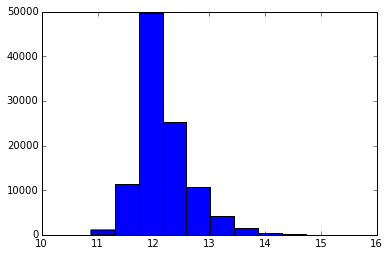

In [335]:
plt.hist(np.log10(halos['mvir']))

(array([  0.00000000e+00,   4.92000000e+02,   3.56200000e+03,
          7.70800000e+03,   9.42500000e+03,   1.04200000e+04,
          1.08330000e+04,   1.06500000e+04,   9.86600000e+03,
          8.55800000e+03,   7.22500000e+03,   5.83400000e+03,
          4.62500000e+03,   3.65500000e+03,   2.78300000e+03,
          2.09300000e+03,   1.60400000e+03,   1.19800000e+03,
          8.92000000e+02,   6.65000000e+02,   5.30000000e+02,
          3.91000000e+02,   3.21000000e+02,   2.46000000e+02,
          1.65000000e+02,   1.29000000e+02,   1.17000000e+02,
          7.00000000e+01,   7.10000000e+01,   6.20000000e+01,
          4.10000000e+01,   3.90000000e+01,   3.20000000e+01,
          2.50000000e+01,   1.80000000e+01,   1.20000000e+01,
          8.00000000e+00,   1.20000000e+01,   3.00000000e+00,
          9.00000000e+00,   1.00000000e+00,   8.00000000e+00,
          9.00000000e+00,   5.00000000e+00,   4.00000000e+00,
          6.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        

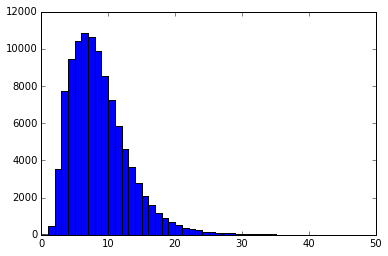

In [336]:
plt.hist(c,range(0,50))

In [337]:
c_med = halos[np.logical_and(halos['rvir']/halos['rs'] > 5, halos['rvir']/halos['rs'] <= 13)]
c_small = halos[halos['rvir']/halos['rs'] <= 5]
c_large = halos[halos['rvir']/halos['rs'] > 13]

In [338]:
mbins = np.logspace(11.5,13,5)

In [339]:
pair_all_list = np.array([sum(count_pairs(halos, mmin, mmax))  for mmin, mmax in  zip(mbins[:-1], mbins[1:]) ])
pair_large_list = np.array([sum(count_pairs(c_large, mmin, mmax))  for mmin, mmax in  zip(mbins[:-1], mbins[1:]) ])
pair_small_list = np.array([sum(count_pairs(c_small, mmin, mmax))  for mmin, mmax in  zip(mbins[:-1], mbins[1:]) ])
pair_med_list = np.array([sum(count_pairs(c_med, mmin, mmax))  for mmin, mmax in  zip(mbins[:-1], mbins[1:]) ])

In [340]:
pair_all_random_list = np.array([sum(count_random_pairs(halos, mmin, mmax))  for mmin, mmax in  zip(mbins[:-1], mbins[1:]) ])
pair_large_random_list = np.array([sum(count_random_pairs(c_large, mmin, mmax))  for mmin, mmax in  zip(mbins[:-1], mbins[1:]) ])
pair_small_random_list = np.array([sum(count_random_pairs(c_small, mmin, mmax))  for mmin, mmax in  zip(mbins[:-1], mbins[1:]) ])
pair_med_random_list = np.array([sum(count_random_pairs(c_med, mmin, mmax))  for mmin, mmax in  zip(mbins[:-1], mbins[1:]) ])

In [341]:
pair_large_random_list

array([ 113.66650052,  391.8713696 ,   61.13926603,   12.4200508 ])

In [342]:
pair_large_list

array([  936.,  2496.,   474.,   162.])

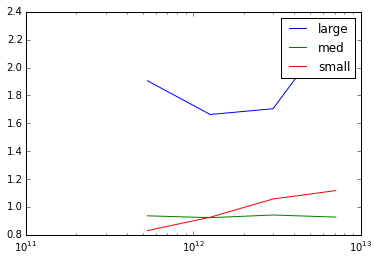

In [343]:
mean = pair_all_list/ pair_all_random_list
plt.semilogx(0.5*(mbins[:-1] + mbins[1:]),pair_large_list/ pair_large_random_list/ mean, label='large')
plt.semilogx(0.5*(mbins[:-1] + mbins[1:]),pair_med_list/ pair_med_random_list /mean, label='med')
plt.semilogx(0.5*(mbins[:-1] + mbins[1:]),pair_small_list/ pair_small_random_list /mean, label='small')
plt.legend()

## precalculated pair counts

In [21]:
#load data
proxies = ['vpeak', 'vmax', 'mvir', 'macc']
cases = ['c250-2048', 'c250-1024', 'c250-768', 'c250-512', 
         'c400-2048', 'c400-1024', 'c400-768', 'c125-2048-new', 'c125-1024']
nd_log_list = np.linspace(-3.3, -1.7, 17)

rbins = np.logspace(-1.3, 1.3, 27)

_pairs_cache = {}
def load_pair_count(proxy, case, nd_log, cumulative=False, fixed_limits=False):
    key = (proxy, case, nd_log, 'f' if fixed_limits else 'c')
    if key not in _pairs_cache:
        _pairs_cache[key] = np.load('/nfs/slac/g/ki/ki06/yymao/resolution_test/pairs_{}/{}_nd{:.1f}_{}.npy'.format(*key)).astype(float)      
    return _pairs_cache[key] if cumulative else np.ediff1d(_pairs_cache[key][::2])

_nd_limits = {}
def load_nd_limits(proxy, case):
    key = (proxy, case)
    if key not in _nd_limits:
        _nd_limits[key] = np.load('/nfs/slac/g/ki/ki06/yymao/resolution_test/pairs_{}/{}_nd_limits.npy'.format(*key))     
    return _nd_limits[key]

def parse_boxname(boxname):
    items = boxname[1:].split('-')
    box_size = float(items[0])
    npart = int(items[1])
    return box_size, npart, (box_size/npart)**3*79379292719.00159

def frexp10(x):
    e = int('{0:e}'.format(float(x)).partition('e')[-1])
    return float(x)/(10.0**e), e

def get_converging_r_index(proxy, case, nd_log, per, fixed_limits=False):
    p = load_pair_count(proxy, case, nd_log, fixed_limits=fixed_limits)
    compared_to = case.partition('-')[0]+'-2048'
    if compared_to == 'c125-2048':
        compared_to += '-new'
    p_2048 = load_pair_count(proxy, compared_to, nd_log, fixed_limits=fixed_limits)
    k = np.where(np.fabs(p/p_2048 - 1.0) > per)[0]
    return (k[-1] + 1) if len(k) else 0

In [12]:
test = load_pair_count('mvir', 'c400-768', -3.3)

In [9]:
load_nd_limits('mvir','c400-768')

array([  8.78100000e+12,   7.02100000e+12,   5.58500000e+12,
         4.40700000e+12,   3.48800000e+12,   2.74800000e+12,
         2.15300000e+12,   1.68200000e+12,   1.30100000e+12,
         1.00900000e+12,   7.73800000e+11,   5.94400000e+11,
         4.59800000e+11,   3.47700000e+11,   2.58000000e+11,
         1.90700000e+11,   2.24300000e+10])

In [10]:
nd_log_list = np.linspace(-3.3, -1.7, 17)

In [11]:
nd_log_list

array([-3.3, -3.2, -3.1, -3. , -2.9, -2.8, -2.7, -2.6, -2.5, -2.4, -2.3,
       -2.2, -2.1, -2. , -1.9, -1.8, -1.7])

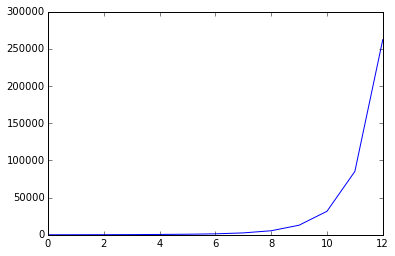

In [14]:
plt.plot(test)

In [ ]:
N = len(halos[['x','y','z']][halos['mvir'] >= m_cut ])
nhalos = N/float(box_size)**3
random = N*nhalos*np.ediff1d(4*np.pi/3.*rbins**3)